In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')


In [3]:
IMG_PATH = f"/kaggle/input/rsna-breast-cancer-1024-pngs/output/"
train["path"] = IMG_PATH + train["patient_id"].astype(str) + "_" + train["image_id"].astype(str) + ".png"
train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-1024-pngs/out...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-1024-pngs/out...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-1024-pngs/out...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-1024-pngs/out...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-1024-pngs/out...


In [4]:
df = train[train.cancer == 1].reset_index(inplace=False)
len(df)

1158

/kaggle/input/rsna-breast-cancer-1024-pngs/output/10668_1222121284.png


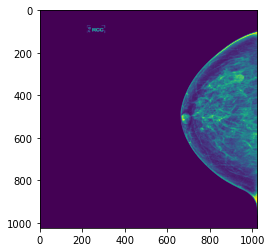

In [5]:
from PIL import Image
from torch.utils.data import Dataset
idx = 19
pillow_image = Image.open(df.path.iloc[idx])
img = np.array(pillow_image)

# img = cv2.imread(df.path.iloc[0])

plt.imshow(img)
print(df.path.iloc[idx])

In [6]:
import albumentations as A
import re


#https://www.kaggle.com/code/davidbroberts/mammography-remove-letter-markers

def Remove_Letter_Markers(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.array(img * 255, dtype = np.uint8)
    # Binarize the image
    bin_img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]

    # Make contours around the binarized image, keep only the largest contour
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
    out = cv2.bitwise_and(img,mask)
    return out


def img2roi(img, is_dicom=False):
    """
    Returns ROI area in other words 
    cuts the image to a desired one
    
    Because there are machine label tags,
    undesired details out of the breast image.
    """
    if not is_dicom:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    img = np.array(img * 255, dtype = np.uint8)
    # Binarize the image
    bin_img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]

    # Make contours around the binarized image, keep only the largest contour
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)

    # Find ROI from largest contour
    ys = contour.squeeze()[:, 0]
    xs = contour.squeeze()[:, 1]
    roi =  img[np.min(xs):np.max(xs), np.min(ys):np.max(ys)]
#     roi = cv2.resize(roi, (1024,1024), cv2.INTER_LINEAR)

#     print(f"Shape of ROI image: {roi.shape}")
    
    return roi

#https://www.kaggle.com/code/vslaykovsky/rsna-cut-off-empty-space-from-images/notebook

def fit_image(X):
    #X = cv2.imread(fname)
    
    # Some images have narrow exterior "frames" that complicate selection of the main data. Cutting off the frame
    X = X[5:-5, 5:-5]
    
    # regions of non-empty pixels
    output= cv2.connectedComponentsWithStats((X > 20).astype(np.uint8)[:, :, 0], 8, cv2.CV_32S)

    # stats.shape == (N, 5), where N is the number of regions, 5 dimensions correspond to:
    # left, top, width, height, area_size
    stats = output[2]

    # finding max area which always corresponds to the breast data. 
    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h
    
    # cutting out the breast data
    X_fit = X[y1: y2, x1: x2]
    
#     patient_id, im_id = re.findall('(\d+)_(\d+).png', os.path.basename(fname))[0]
#     os.makedirs(patient_id, exist_ok=True)
#     cv2.imwrite(f'{patient_id}/{im_id}.png', X_fit[:, :, 0])
    return X_fit[:, :, 0]


def get_transform(stage):
    if stage == 'train':
        return A.Compose([
            A.RandomBrightnessContrast(p=0.2),
        #     A.PiecewiseAffine(p=1.0),
            A.ShiftScaleRotate(
                        shift_limit=0.0625,
                        scale_limit=0.1,
                        rotate_limit=30,
                        p=1.0),
        #     A.Transpose(always_apply=False, p=1.0),
        #     A.CenterCrop(always_apply=False, p=1.0, height=512, width=512),
#             A.RandomScale(always_apply=False, p=1.0, interpolation=0, scale_limit=(-0.09999999999999998, 0.10000000000000009)),
            A.Sharpen(always_apply=False, p=1.0, alpha=(0.2, 0.5), lightness=(1.0, 1.0)),
        #     A.dropout.coarse_dropout.CoarseDropout (max_holes=1, max_height=256, max_width=256, min_holes=None, min_height=None, min_width=None, fill_value=0, mask_fill_value=None, always_apply=False, p=0.9),
        #     A.AdvancedBlur(always_apply=False, p=1.0, blur_limit=(3, 7), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=(-90, 90), beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1)),
        #     A.MultiplicativeNoise (multiplier=(0.9, 1.1), per_channel=False, elementwise=False, always_apply=False, p=0.5),
            A.augmentations.geometric.resize.Resize(1024,1024),
            #     A.ISONoise (color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=0.5),
        #     A.ChannelShuffle(p=0.6),
        #     A.dropout.channel_dropout.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5),
        # #     A.RandomSnow (snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=2.5, always_apply=False, p=0.5),
        #     A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
        ])
    if stage == 'train_v1':
        return A.Compose([
        #     A.PiecewiseAffine(p=1.0),
#               A.geometric.transforms.Affine(scale=(0.5, 2.0), translate_percent=(0.1, 0.1), translate_px=None, rotate=(5,5),                              shear=30, interpolation=1, mask_interpolation=0, cval=0, cval_mask=0, mode=0,                                                   fit_output=False,keep_ratio=False, always_apply=False, p=0.5),
            
        #     A.Transpose(always_apply=False, p=1.0),
#             A.CenterCrop(always_apply=False, p=1.0, height=900, width=900),
#             A.RandomScale(always_apply=False, p=1.0, interpolation=0, scale_limit=(-0.09999999999999998, 0.10000000000000009)),
            A.MedianBlur(always_apply=False, p=1.0, blur_limit=(1, 3)),
            #     A.AdvancedBlur(always_apply=False, p=1.0, blur_limit=(3, 7), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=(-90, 90), beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1)),
        #     A.MultiplicativeNoise (multiplier=(0.9, 1.1), per_channel=False, elementwise=False, always_apply=False, p=0.5),
            A.augmentations.geometric.resize.Resize(1024,1024),
            #     A.ISONoise (color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=0.5),
#             A.ChannelShuffle(p=0.6),
            A.ColorJitter(always_apply=False, p=1.0, brightness=(0.73, 0.83), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2)),
        #     A.dropout.channel_dropout.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5),
        # #     A.RandomSnow (snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=2.5, always_apply=False, p=0.5),
            A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
        ])
    if stage == 'train_v2':
        return A.Compose([
     
            A.augmentations.geometric.resize.Resize(1024,1024),
#             A.ISONoise (color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=0.3),
            A.ChannelShuffle(p=0.5),
#             A.RandomSnow (snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=2.5, always_apply=False, p=0.5),

            A.ColorJitter(always_apply=False, p=0.5, brightness=(0.1, 0.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2)),

        ])



In [7]:
def BreastCancerData(df,transform=None):
    os.makedirs('augmented_dataset',exist_ok=True)
    df['img_name'] = "none"
    df['aug_img_name'] = "none"
    for idx in range(len(df)):
        head, tail = os.path.split(df.path[idx])
        image = cv2.cvtColor(cv2.imread(df.path[idx],cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
#         image = cv2.imread(df.path[idx])
        df['img_name'][idx] = tail
        df['aug_img_name'][idx] = "aug_"+tail
        
        #             image = np.asarray(Image.open(self.paths[idx]).convert('RGB'))
        

#         image = (image * 255).astype(np.uint8)
#         image = img2roi(image, is_dicom=False)
#         image = cv2.resize(image,(1024,1024), interpolation=cv2.INTER_LINEAR)

        #             image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        #         image = image.astype(np.float32)
        image = Remove_Letter_Markers(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if transform=='valid':
            valid_aug = get_transform(stage='valid')
        #             image = valid_aug(image)
            image = valid_aug(image=image)['image']
        if transform=='train':
            train_aug = get_transform(stage='train')
        #             image = train_aug(image)
            image = train_aug(image=image)['image']
            
        if transform=='train_v1':
            train_aug = get_transform(stage='train_v1')
        #             image = train_aug(image)
            image = train_aug(image=image)['image']
        if transform=='train_v2':
            train_aug = get_transform(stage='train_v2')
        #             image = train_aug(image)
            image = train_aug(image=image)['image']
            
        image = fit_image(image)
        image = cv2.resize(image,(1024,1024), interpolation=cv2.INTER_LINEAR)

        #         image = image / 255
        cv2.imwrite(f"augmented_dataset/{df['aug_img_name'][idx]}", image)
    df.to_csv("augmented_df.csv",index = False)




In [8]:
!ls

__notebook__.ipynb


(1024, 1024, 3)


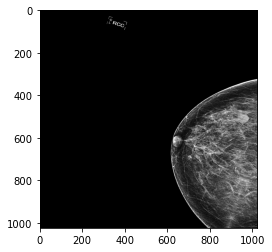

In [9]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = get_transform(stage='train')
Transformed_Img = transform(image = img)["image"]
print(Transformed_Img.shape)
plt.imshow(Transformed_Img)

In [10]:

head, tail = os.path.split(df.path[0])
"augmented_"+tail

'augmented_10130_388811999.png'

In [11]:
%%time

BreastCancerData(df,transform="train_v2")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


CPU times: user 1min 39s, sys: 35.9 s, total: 2min 15s
Wall time: 1min 18s


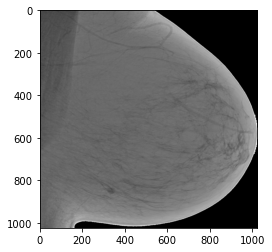

In [12]:
plt.imshow(cv2.imread('/kaggle/working/augmented_dataset/aug_45810_2129233566.png'))